### Frameworks e Bibliotecas

In [1]:
# Imports

import pandas as pd
import numpy as np
import math
import warnings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import locale

from datetime import datetime

import statsmodels
from statsmodels.tsa.seasonal import MSTL

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import pmdarima as pm

locale.setlocale(locale.LC_TIME, "pt_BR.UTF-8")
plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams["mathtext.fontset"] = "custom"
matplotlib.rcParams["mathtext.bf"] = "Arial:bold"
matplotlib.rcParams["mathtext.it"] = "Arial:italic"

warnings.filterwarnings("ignore", category=UserWarning)

### Leitura dos Dados

In [2]:
df = pd.read_excel("../data/Desafio Inteligência (Cientista de Dados).xlsx")

### Limpeza dos Dados

In [3]:
df.categoria_veiculo = df.categoria_veiculo.replace(
    {"IntermediÃ¡rio": "Intermediário", "EconÃ´mico": "Econômico"}
)

for column_name in df.columns:
    if "Unnamed" in column_name:
        df.drop(column_name, axis=1, inplace=True)

df.drop(["cidade", "estado"], axis=1, inplace=True)

df.id_loja = df.id_loja.str.replace("LJ_", "Loja ")

rename_columns = {
    "data_inicio_locacao": "Data de Início da Locação",
    "duracao_locacao": "Duração da Locação",
    "dias_antecedencia": "Dias de Antecedência",
    "diaria_media": "Diária Média",
    "valor_total_locacao": "Valor Total da Locação",
    "id_loja": "ID da Loja",
    "id_contrato": "ID do Contrato",
    "categoria_veiculo": "Categoria do Veículo",
}

df.rename(columns=rename_columns, inplace=True)

numerical_columns = [
    "Duração da Locação",
    "Dias de Antecedência",
    "Diária Média",
    "Valor Total da Locação",
]
categorical_columns = ["ID da Loja", "ID do Contrato", "Categoria do Veículo"]

### Estatísticas Gerais

In [61]:
# Display Dataframe
# Visualização das principais estatísticas do conjunto de dados

display(df.head())
display(df.info())
display(df.describe())

,ID do Contrato,Data de Início da Locação,Duração da Locação,ID da Loja,Dias de Antecedência,Categoria do Veículo,Diária Média,Valor Total da Locação
0,CTR0000001,2022-01-27,8,Loja 01,13,Econômico,91.22,729.76
1,CTR0000002,2022-01-31,9,Loja 01,9,Intermediário,78.70,708.30
2,CTR0000003,2022-01-10,7,Loja 01,16,SUV,143.14,1001.98
3,CTR0000004,2022-01-28,7,Loja 01,4,Intermediário,135.86,951.02
4,CTR0000005,2022-01-28,9,Loja 01,9,Intermediário,104.02,936.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140249 entries, 0 to 140248
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID do Contrato             140249 non-null  object        
 1   Data de Início da Locação  140249 non-null  datetime64[ns]
 2   Duração da Locação         140249 non-null  int64         
 3   ID da Loja                 140249 non-null  object        
 4   Dias de Antecedência       140249 non-null  int64         
 5   Categoria do Veículo       140249 non-null  object        
 6   Diária Média               140249 non-null  float64       
 7   Valor Total da Locação     140249 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 8.6+ MB


None

,Data de Início da Locação,Duração da Locação,Dias de Antecedência,Diária Média,Valor Total da Locação
count,140249,140249.000000,140249.000000,140249.000000,140249.000000
mean,2023-03-13 18:31:13.553465600,6.347439,15.019287,120.045161,761.950563
min,2022-01-01 00:00:00,1.000000,0.000000,-5.190000,-31.140000
25%,2022-08-01 00:00:00,5.000000,7.000000,99.750000,516.800000
50%,2023-02-24 00:00:00,6.000000,15.000000,120.140000,728.560000
75%,2023-11-03 00:00:00,8.000000,23.000000,140.220000,970.740000
max,2024-06-30 00:00:00,16.000000,30.000000,259.860000,2875.800000
std,NaN,2.271802,8.943597,30.002451,339.808277


### Histogramas

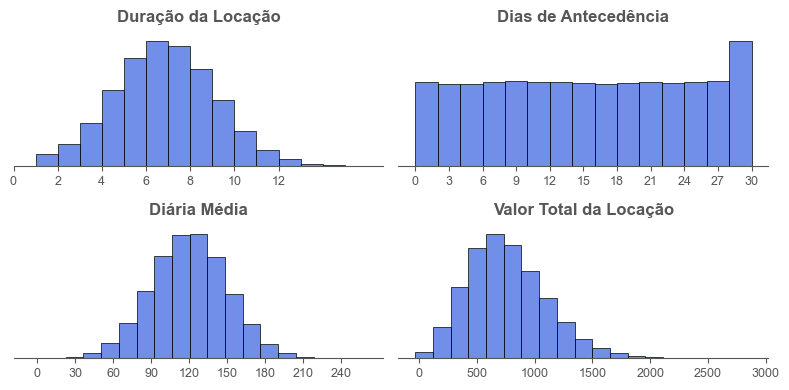

In [5]:
# Auxiliary Functions


def sturges_bins(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n <= 1:
        return 1, np.inf

    k = math.ceil(math.log2(n)) + 1
    data_range = x.max() - x.min()
    h = data_range / k if data_range > 0 else np.inf
    h = math.ceil(h)
    return k, h


def config_histogram(ax, title_text):
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=9, color="#555655")
    ax.get_yaxis().set_visible(False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    # Título
    ax.text(
        0.5,
        1.1,
        title_text,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="semibold",
        color="#555655",
        ha="center",  # centraliza horizontalmente
    )

    plt.tight_layout()


# Plot

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 4), constrained_layout=True)
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    k, h = sturges_bins(df.loc[:, col].values)
    sns.histplot(data=df, x=col, ax=axes[idx], bins=k, binwidth=h, linewidth=0.5, color="#4169E1")

    if col == "Duração da Locação":
        axes[idx].set_xticks(range(0, 14, 2))
    elif col == "Dias de Antecedência":
        axes[idx].set_xticks(range(0, 31, 3))
    elif col == "Diária Média":
        axes[idx].set_xticks(range(0, 251, 30))

    config_histogram(ax=axes[idx], title_text=col)

plt.savefig("../img/results/histograms.png", dpi=600, bbox_inches="tight")

### Gráficos de Pareto

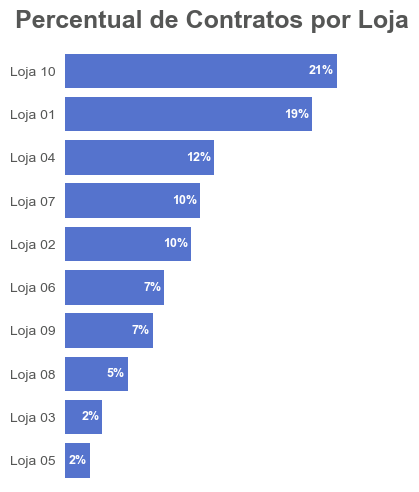

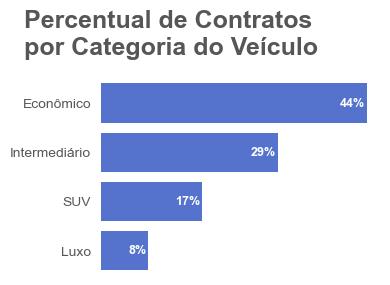

In [6]:
# Auxiliary Functions


def config_pareto(ax, title_text, title_loc):
    ax.tick_params(color="#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.setp(ax.get_yticklabels(), fontsize=10, color="#555655")
    ax.get_xaxis().set_visible(False)
    ax.tick_params(left=False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    # Título
    ax.text(
        *title_loc,
        title_text,
        transform=ax.transAxes,
        fontsize=18,
        fontweight="semibold",
        color="#555655",
    )

    for p in ax.patches:
        percent = int(p.get_width() * 100)
        text = f"{percent}%"

        x = p.get_width() - 0.0025
        y = p.get_y() + p.get_height() / 2

        ax.text(
            x,
            y,
            text,
            fontweight="semibold",
            ha="right",
            va="center",
            fontsize=9,
            color="white",
        )

    plt.tight_layout()


# Plot

for col in categorical_columns:
    if col != "ID do Contrato":
        if col == "ID da Loja":
            title_text = "Percentual de Contratos por Loja"
            title_loc = (-0.175, 1.05)
            file_name = "store"
            fig, ax = plt.subplots(figsize=(4, 5), constrained_layout=True)
        else:
            title_text = "Percentual de Contratos \npor " + col
            title_loc = (-0.275, 1.125)
            file_name = "vehicle_category"
            fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)

        rel_freq = df[col].value_counts(normalize=True).reset_index()
        rel_freq.columns = [col, "percent"]

        order = rel_freq[col]

        sns.barplot(
            data=rel_freq,
            y=col,
            x="percent",
            order=order,
            ax=ax,
            color="#4169E1",
        )

        config_pareto(ax=ax, title_text=title_text, title_loc=title_loc)

        plt.savefig(f"../img/results/contracts_by_{file_name}.png", dpi=600, bbox_inches="tight")

### Análise de Desempenho e Rentabilidade

In [7]:
df_summary_vehicles = df.groupby("Categoria do Veículo").agg(
    Quantidade_de_Contratos=("Categoria do Veículo", "count"),
    Receita_Total=("Valor Total da Locação", "sum"),
    Ticket_Medio=("Valor Total da Locação", "mean"),
    Diaria_Media=("Diária Média", "mean"),
    Duracao_Media_da_Locacao=("Duração da Locação", "mean"),
    Dias_de_Antecedencia_Media=("Dias de Antecedência", "mean"),
)

cols_to_round_and_convert = [
    "Receita_Total",
    "Ticket_Medio",
    "Diaria_Media",
    "Duracao_Media_da_Locacao",
    "Dias_de_Antecedencia_Media",
]

for col in cols_to_round_and_convert:
    df_summary_vehicles[col] = df_summary_vehicles[col].round(0).astype(int)

df_summary_vehicles.rename(
    columns={
        "Quantidade_de_Contratos": "Quantidade de Contratos",
        "Receita_Total": "Receita Total",
        "Ticket_Medio": "Ticket Médio",
        "Diaria_Media": "Diária Média",
        "Duracao_Media_da_Locacao": "Duração Média da Locação",
        "Dias_de_Antecedencia_Media": "Dias de Antecedência Média",
    },
    inplace=True,
)

display(df_summary_vehicles)

,Quantidade de Contratos,Receita Total,Ticket Médio,Diária Média,Duração Média da Locação,Dias de Antecedência Média
Categoria do Veículo,,,,,,
Econômico,63071,48118073,763,120,6,15
Intermediário,41950,31933378,761,120,6,15
Luxo,11246,8612374,766,120,6,15
SUV,23982,18198979,759,120,6,15


In [8]:
df_summary_stores = df.groupby("ID da Loja").agg(
    Quantidade_de_Contratos=("ID do Contrato", "count"),
    Receita_Total=("Valor Total da Locação", "sum"),
    Ticket_Medio=("Valor Total da Locação", "mean"),
    Diaria_Media=("Diária Média", "mean"),
    Duracao_Media_da_Locacao=("Duração da Locação", "mean"),
    Dias_de_Antecedencia_Media=("Dias de Antecedência", "mean"),
)

cols_to_round_and_convert = [
    "Receita_Total",
    "Ticket_Medio",
    "Diaria_Media",
    "Duracao_Media_da_Locacao",
    "Dias_de_Antecedencia_Media",
]

for col in cols_to_round_and_convert:
    df_summary_stores[col] = df_summary_stores[col].round(0).astype(int)

df_summary_stores.rename(
    columns={
        "ID da Loja": "Lojas",
        "Quantidade_de_Contratos": "Quantidade de Contratos",
        "Receita_Total": "Receita Total",
        "Ticket_Medio": "Ticket Médio",
        "Diaria_Media": "Diária Média",
        "Duracao_Media_da_Locacao": "Duração Média da Locação",
        "Dias_de_Antecedencia_Media": "Dias de Antecedência Média",
    },
    inplace=True,
)

display(df_summary_stores)

,Quantidade de Contratos,Receita Total,Ticket Médio,Diária Média,Duração Média da Locação,Dias de Antecedência Média
ID da Loja,,,,,,
Loja 01,27964,21335090,763,120,6,15
Loja 02,14253,10804280,758,120,6,15
Loja 03,4204,3191594,759,119,6,15
Loja 04,16843,12797305,760,120,6,15
Loja 05,2806,2097845,748,120,6,15
Loja 06,11215,8522087,760,120,6,15
Loja 07,15279,11685328,765,120,6,15
Loja 08,7051,5407191,767,120,6,15
Loja 09,9911,7571707,764,120,6,15


In [9]:
df_rentability_total = (
    df.groupby(["ID da Loja", "Categoria do Veículo"])["Valor Total da Locação"]
    .sum()
    .reset_index()
)

idx_max_rentabilidade = df_rentability_total.groupby("ID da Loja")[
    "Valor Total da Locação"
].idxmax()

most_profitable_category_by_store = df_rentability_total.loc[idx_max_rentabilidade]
most_profitable_category_by_store["Valor Total da Locação"] = (
    most_profitable_category_by_store["Valor Total da Locação"].round(0).astype(int)
)
most_profitable_category_by_store.rename(
    columns={"Valor Total da Locação": "Valor Total de Locação"},
    inplace=True,
)

most_profitable_category_by_store = most_profitable_category_by_store.reset_index(
    drop=True
)

display(most_profitable_category_by_store)

,ID da Loja,Categoria do Veículo,Valor Total de Locação
0,Loja 01,Econômico,9478309
1,Loja 02,Econômico,4910746
2,Loja 03,Econômico,1459255
3,Loja 04,Econômico,5802909
4,Loja 05,Econômico,956739
5,Loja 06,Econômico,3778492
6,Loja 07,Econômico,5306427
7,Loja 08,Econômico,2394097
8,Loja 09,Econômico,3407965
9,Loja 10,Econômico,10623134


In [10]:
df_rentability_mean = (
    df.groupby(["ID da Loja", "Categoria do Veículo"])["Valor Total da Locação"]
    .mean()
    .reset_index()
)
idx_max_rentabilidade = df_rentability_mean.groupby("ID da Loja")[
    "Valor Total da Locação"
].idxmax()
most_profitable_category_by_store = df_rentability_mean.loc[idx_max_rentabilidade]
most_profitable_category_by_store["Valor Total da Locação"] = (
    most_profitable_category_by_store["Valor Total da Locação"].round(0).astype(int)
)

most_profitable_category_by_store.rename(
    columns={"Valor Total da Locação": "Ticket Médio"},
    inplace=True,
)

most_profitable_category_by_store = most_profitable_category_by_store.reset_index(
    drop=True
)

display(most_profitable_category_by_store)

,ID da Loja,Categoria do Veículo,Ticket Médio
0,Loja 01,SUV,765
1,Loja 02,Luxo,778
2,Loja 03,Intermediário,767
3,Loja 04,Luxo,778
4,Loja 05,Intermediário,761
5,Loja 06,SUV,766
6,Loja 07,Luxo,781
7,Loja 08,SUV,772
8,Loja 09,Luxo,770
9,Loja 10,Econômico,764


### Análise da Correlação das Variáveis

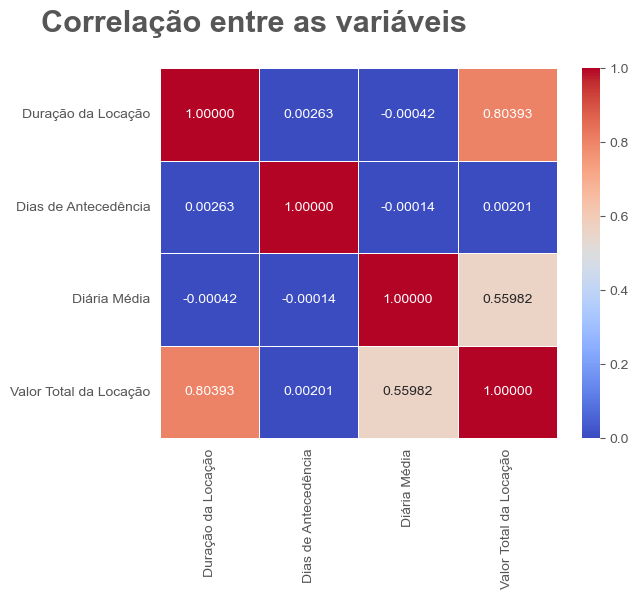

In [11]:
corr_matrix = df.loc[:, numerical_columns].corr()

plt.figure()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".5f", linewidths=0.5)

plt.setp(
    [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=10, color="#555655"
)
ax.tick_params(left=False, bottom=False)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(colors="#555655")

# Título
ax.text(
    -0.3, 1.1,
    "Correlação entre as variáveis",
    transform=ax.transAxes,
    fontsize=22,
    fontweight="semibold",
    color="#555655",
)

plt.savefig("../img/results/matrix_corr.png", dpi=600, bbox_inches="tight")


### Perguntas Chaves

**Principais Métricas de Locação**

* **Estatísticas Gerais**

    * **Qual a diária média das locações?** Avaliar a correlação entre diária média e número de locações. Qual o impacto de preço na demanda? Gerar um gráfico de dispersão entre as variáveis.

    * **Qual o ticket médio dos contratos de locação?** R: R$ 761,95

    * **Qual a duração (mínimo, média, máximo) de uma locação?** Gerar um histograma, categorizando em curtas (<3 dias), médias (3–7 dias) e longas (>7 dias)​.

    * **Com quantos dias de antecedência, em média, os clientes reservam?** Comparativo de reservas planejadas e de última hora.

    * **Clientes que fazem reservas planejadas gastam mais?**

* **Performance por Categoria de Veículo**

    * **Qual categoria é mais contratada (participação de mercado)?** R: Econômica.

    * **Qual a receita por categoria?** Avaliar se existe diferença quando analisado valores absolutos e relativos. R: Econômica.

    * **Qual o ticket médio de cada categoria?**
    
    * **Qual categoria é mais contratada em reserva planejada e de última hora?** R: Em ambos os casos é a econômica.

* **Performance das Unidades**

    * **Qual o volume operacional (número de contratos) de cada loja?**

    * **Qual a receita total de cada loja?**
    
    * **Qual a taxa de ocupação média?**

    * **Categoria possui a maior rentabilidade em cada loja?**

    * **Quais lojas sustentam o negócio e quais precisam de atenção​?**

In [12]:
def config_histogram(ax, title_text):
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=9, color="#555655")
    ax.get_yaxis().set_visible(False)

    ax.set_xlabel("")
    ax.set_ylabel("")

    # Título
    ax.text(
        -0.05,
        1.125,
        title_text,
        transform=ax.transAxes,
        fontsize=18,
        fontweight="semibold",
        color="#555655",
    )

    plt.tight_layout()


def config_scatter_plot(ax, title, x_label, y_label):
    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=10, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel(x_label, loc="left", fontsize=10, color="#555655")
    ax.set_ylabel(y_label, loc="top", fontsize=10, color="#555655")

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=18,
        fontweight="semibold",
        color="#555655",
    )


def config_heatmap(ax, title, title_loc, subtitle, subtitle_loc):
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=10, color="#555655"
    )
    ax.tick_params(left=False, bottom=False)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(colors="#555655")

    ax.text(
        *title_loc,
        title,
        transform=ax.transAxes,
        fontsize=18,
        fontweight="semibold",
        color="#555655",
    )

    ax.text(
        *subtitle_loc,
        subtitle,
        transform=ax.transAxes,
        fontsize=14,
        color="#555655",
    )

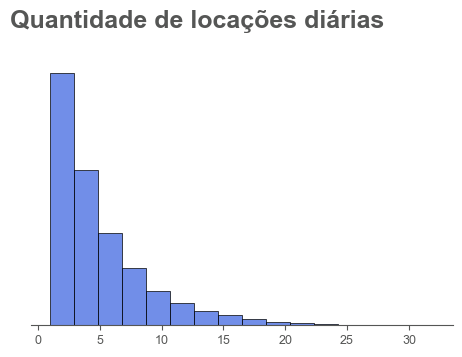

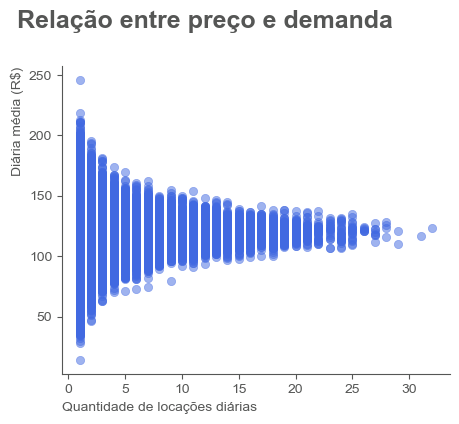

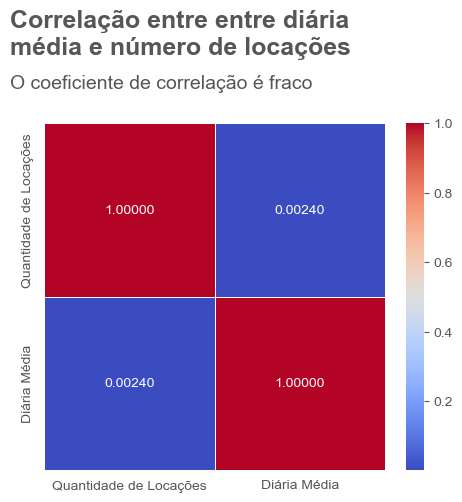

In [13]:
# Correlação entre entre diária média e número de locações

df_grouped = (
    df.groupby(["Data de Início da Locação", "ID da Loja", "Categoria do Veículo"])
    .agg({"ID do Contrato": "count", "Diária Média": "mean"})
    .rename(columns={"ID do Contrato": "Quantidade de Locações"})
)
df_grouped.reset_index(drop=True, inplace=True)
corr_matrix = df_grouped.corr()

# Histrograma

k, h = sturges_bins(df_grouped["Quantidade de Locações"].values)

fig = plt.figure(figsize=(4.7, 3.7))
ax = sns.histplot(
    data=df_grouped,
    x="Quantidade de Locações",
    bins=k,
    binwidth=h,
    linewidth=0.5,
    color="#4169E1",
)
config_histogram(ax, title_text="Quantidade de locações diárias")

# Gráfico de dispersão

plt.figure(figsize=(5, 4))
ax = sns.scatterplot(
    x=df_grouped["Quantidade de Locações"],
    y=df_grouped["Diária Média"],
    edgecolor=None,
    facecolor="#4169E1",
    alpha=0.5,
)
config_scatter_plot(
    ax,
    title="Relação entre preço e demanda",
    x_label="Quantidade de locações diárias",
    y_label="Diária média (R$)",
)

# Correlação

plt.figure(figsize=(5.5, 4.5))
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".5f", linewidths=0.5)
config_heatmap(
    ax,
    title="Correlação entre entre diária \nmédia e número de locações",
    title_loc=(-0.1, 1.2),
    subtitle="O coeficiente de correlação é fraco",
    subtitle_loc=(-0.1, 1.1),
)

Curta Duração: 4.55%
Média Duração: 64.89%
Longa Duração: 30.56%


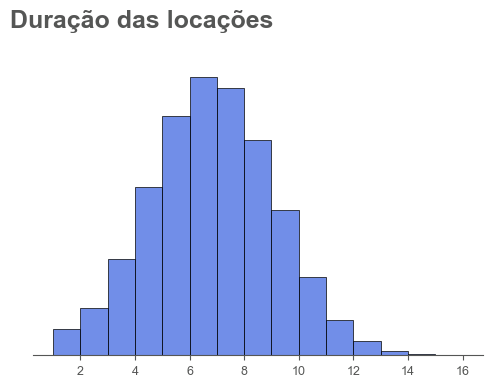

In [14]:
duration_of_rental = df["Duração da Locação"].values
short_durations = duration_of_rental[duration_of_rental < 3]
medium_durations = duration_of_rental[
    (duration_of_rental >= 3) & (duration_of_rental <= 7)
]
long_durations = duration_of_rental[duration_of_rental > 7]

plt.figure(figsize=(5, 4))
ax = sns.histplot(data=duration_of_rental, binwidth=1, linewidth=0.5, color="#4169E1")
config_histogram(ax, title_text="Duração das locações")

print(f"Curta Duração: {round(len(short_durations)*100/len(duration_of_rental), 2)}%")
print(f"Média Duração: {round(len(medium_durations)*100/len(duration_of_rental), 2)}%")
print(f"Longa Duração: {round(len(long_durations)*100/len(duration_of_rental), 2)}%")

Reservas de última hora: 3.17%
Reservas na última semana: 19.22%
Reservas planejadas: 77.6%


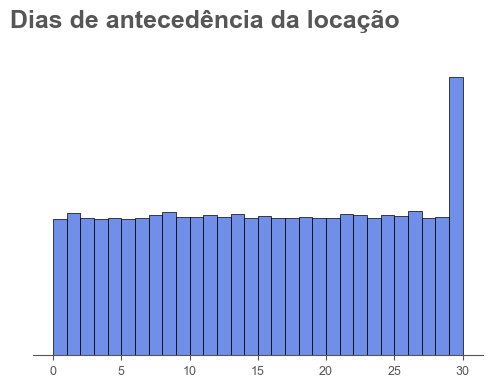

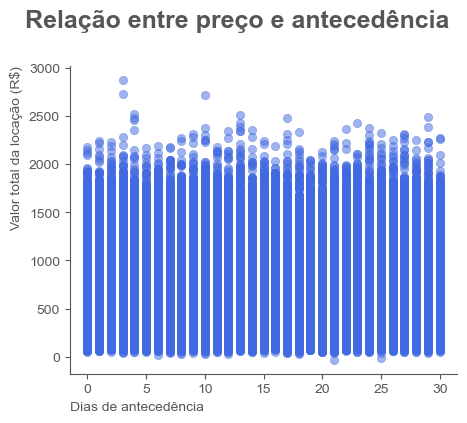

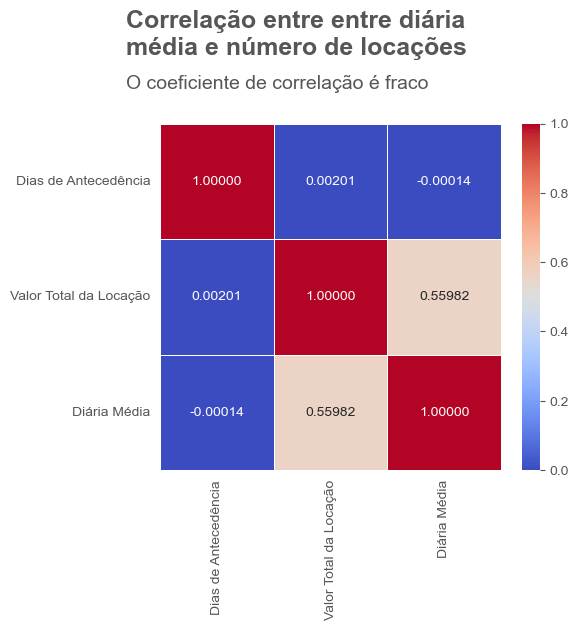

In [15]:
days_in_advance = df["Dias de Antecedência"].values

reserve_less_than_one_day = days_in_advance[days_in_advance < 1]
reserve_less_than_a_week = days_in_advance[
    (days_in_advance >= 1) & (days_in_advance < 7)
]
planned_reservations = days_in_advance[days_in_advance >= 7]

print(
    f"Reservas de última hora: {round(len(reserve_less_than_one_day)*100/len(days_in_advance), 2)}%"
)
print(
    f"Reservas na última semana: {round(len(reserve_less_than_a_week)*100/len(days_in_advance), 2)}%"
)
print(
    f"Reservas planejadas: {round(len(planned_reservations)*100/len(days_in_advance), 2)}%"
)

# Histograma

plt.figure(figsize=(5, 4))
ax = sns.histplot(data=days_in_advance, binwidth=1, linewidth=0.5, color="#4169E1")
config_histogram(ax, title_text="Dias de antecedência da locação")

# Gráfico de dispersão

plt.figure(figsize=(5, 4))
ax = sns.scatterplot(
    x=df["Dias de Antecedência"],
    y=df["Valor Total da Locação"],
    edgecolor=None,
    facecolor="#4169E1",
    alpha=0.5,
)
config_scatter_plot(
    ax,
    title="Relação entre preço e antecedência",
    x_label="Dias de antecedência",
    y_label="Valor total da locação (R$)",
)

# Correlação

corr_matrix = df[
    ["Dias de Antecedência", "Valor Total da Locação", "Diária Média"]
].corr()

plt.figure(figsize=(5.5, 4.5))
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".5f", linewidths=0.5)
config_heatmap(
    ax,
    title="Correlação entre entre diária \nmédia e número de locações",
    title_loc=(-0.1, 1.2),
    subtitle="O coeficiente de correlação é fraco",
    subtitle_loc=(-0.1, 1.1),
)

In [16]:
df_temp = df.copy()

bins = [-1, 1, 7, float("inf")]
labels = ["Última Hora", "Última Semana", "Planejada"]
df_temp["Categoria da Antecedência"] = pd.cut(
    df_temp["Dias de Antecedência"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True,
)

palette = {"Planejada": "#174A7E", "Última Semana": "#4A81BF", "Última Hora": "#94B2D7"}

fig = plt.figure(figsize=(5, 4))
ax = sns.histplot(
    data=df_temp,
    x="Categoria do Veículo",
    hue="Categoria da Antecedência",
    multiple="stack",
    palette=palette,
    shrink=0.8,
    linewidth=0.5,
)
config_histogram(ax, title_text="Categoria do veículo por \nantecedência da locação")
plt.close(fig)

In [17]:
df_temp = df.copy()
df_temp["Data de Início da Locação"] = pd.to_datetime(
    df_temp["Data de Início da Locação"]
)
df_temp["Duração da Locação"] = pd.to_numeric(df_temp["Duração da Locação"])

# Calcula a data de fim da locação
df_temp["Data de Fim da Locação"] = df_temp[
    "Data de Início da Locação"
] + pd.to_timedelta(df_temp["Duração da Locação"], unit="D")

# Cria uma lista de datas para cada locação.
df_temp["Datas"] = [
    pd.date_range(start, end - pd.Timedelta(days=1), freq="D")
    for start, end in zip(
        df_temp["Data de Início da Locação"], df_temp["Data de Fim da Locação"]
    )
]

# Cria uma linha para cada dia de locação.
expanded = df_temp.explode("Datas").rename(columns={"Datas": "Data"})

# Conta quantos contratos ativos por loja e por dia
daily_occupancy = expanded.groupby(["Data", "ID da Loja"]).size().unstack(fill_value=0)

# Calcula a ocupação média por loja
average_occupancy_df = daily_occupancy.mean().reset_index()
average_occupancy_df.columns = ["ID da Loja", "Ocupação Média"]
average_occupancy_df["Ocupação Média"] = (
    average_occupancy_df["Ocupação Média"].round(0).astype(int)
)

# Calcula a ocupação máxima por loja
max_occupancy_df = daily_occupancy.max().reset_index()
max_occupancy_df.columns = ["ID da Loja", "Ocupação Máxima"]

display(daily_occupancy)
display(average_occupancy_df)
display(max_occupancy_df)

ID da Loja,Loja 01,Loja 02,Loja 03,Loja 04,Loja 05,Loja 06,Loja 07,Loja 08,Loja 09,Loja 10
Data,,,,,,,,,,
2022-01-01,51,35,4,38,4,13,19,13,14,42
2022-01-02,89,48,11,64,9,34,46,23,26,92
2022-01-03,139,69,17,94,11,53,71,39,42,130
2022-01-04,178,94,23,121,18,67,98,51,58,182
2022-01-05,223,113,30,146,20,80,119,61,76,212
...,...,...,...,...,...,...,...,...,...,...
2024-07-05,19,9,3,9,1,4,10,2,6,14
2024-07-06,7,4,1,4,0,3,5,1,4,8
2024-07-07,0,2,1,1,0,2,2,0,2,3


,ID da Loja,Ocupação Média
0,Loja 01,193
1,Loja 02,98
2,Loja 03,29
3,Loja 04,116
4,Loja 05,19
5,Loja 06,77
6,Loja 07,106
7,Loja 08,49
8,Loja 09,68
9,Loja 10,212


,ID da Loja,Ocupação Máxima
0,Loja 01,372
1,Loja 02,182
2,Loja 03,65
3,Loja 04,220
4,Loja 05,44
5,Loja 06,145
6,Loja 07,207
7,Loja 08,101
8,Loja 09,145
9,Loja 10,412


### Análise Temporal

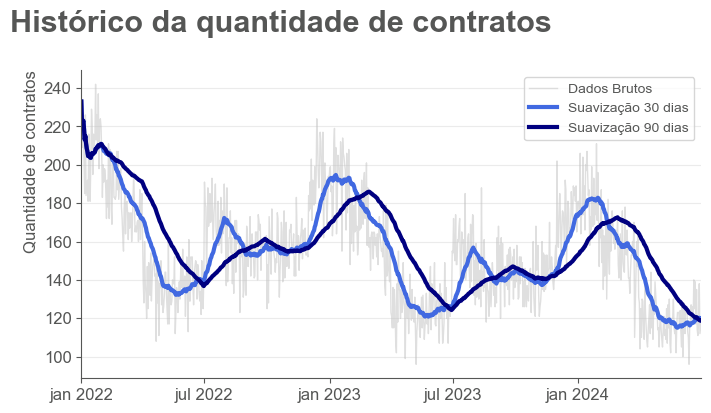

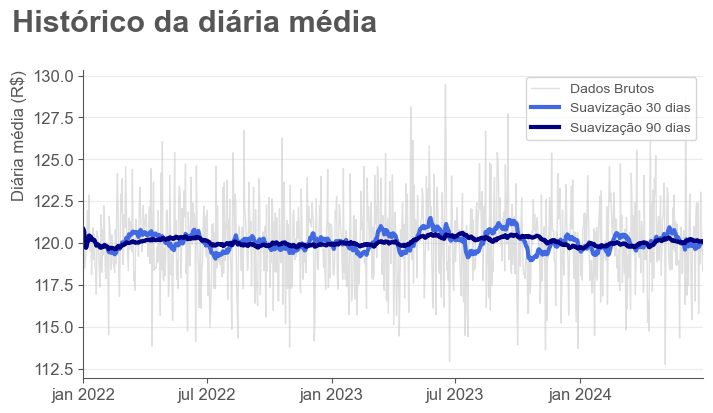

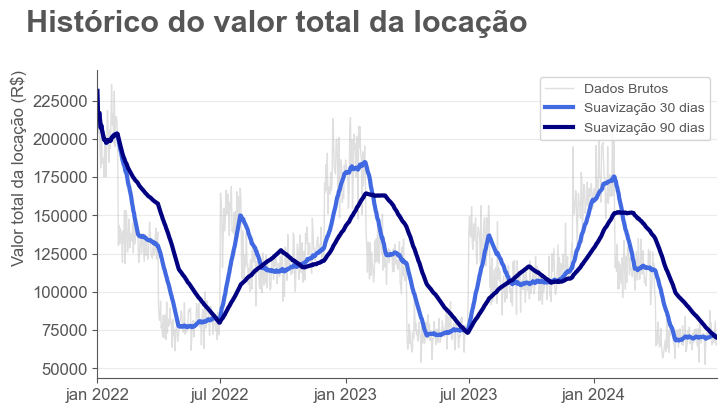

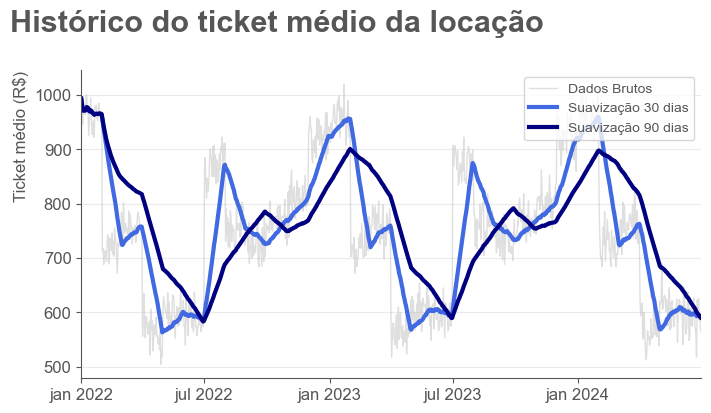

In [18]:
# Dados Brutos e Médias Móveis (Suavização)


def config_time_series_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper right", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )


def time_series_plot(
    df: pd.DataFrame, title: str, column: str, y_label: str, filename: str = None
):
    # Processamento dos Dados
    if column == "ID do Contrato":
        agg_function = "count"
    elif column == "Valor Total da Locação":
        agg_function = "sum"
    else:
        agg_function = "mean"

    df_time_series = (
        df.groupby(df["Data de Início da Locação"].dt.date)
        .agg({column: agg_function})
        .reset_index()
    )
    df_time_series.rename(
        columns={"Data de Início da Locação": "Data", column: "Dados Brutos"},
        inplace=True,
    )
    df_time_series["Data"] = pd.to_datetime(df_time_series["Data"])
    min_date = df_time_series["Data"].min()
    max_date = df_time_series["Data"].max()
    df_time_series.set_index("Data", inplace=True)

    # Cálculo
    df_time_series["Suavização 30 dias"] = (
        df_time_series["Dados Brutos"].rolling(window="30D").mean()
    )
    df_time_series["Suavização 90 dias"] = (
        df_time_series["Dados Brutos"].rolling(window="90D").mean()
    )

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))

    colors = {
        "Dados Brutos": "#C0C0C080",
        "Suavização 30 dias": "#4169E1",
        "Suavização 90 dias": "#000080",
    }
    widths = {"Dados Brutos": 1, "Suavização 30 dias": 3, "Suavização 90 dias": 3}

    for series_name in colors.keys():
        ax.plot(
            df_time_series.index,
            df_time_series[series_name],
            color=colors[series_name],
            linewidth=widths[series_name],
            label=series_name,
        )

    config_time_series_plot(ax, title, y_label, min_date, max_date)

    if filename:
        plt.savefig(f"../img/results/{filename}.png", dpi=600, bbox_inches="tight")


# Execution

time_series_plot(
    df,
    title="Histórico da quantidade de contratos",
    column="ID do Contrato",
    y_label="Quantidade de contratos",
    filename="history of the number of contracts".replace(" ", "_"),
)

time_series_plot(
    df,
    title="Histórico da diária média",
    column="Diária Média",
    y_label="Diária média (R$)",
    filename="history of the average daily rate".replace(" ", "_"),
)

time_series_plot(
    df,
    title="Histórico do valor total da locação",
    column="Valor Total da Locação",
    y_label="Valor total da locação (R$)",
    filename="total rental value history".replace(" ", "_"),
)

df_temp = df.copy()
df_temp["Ticket Médio"] = df_temp["Valor Total da Locação"]
time_series_plot(
    df_temp,
    title="Histórico do ticket médio da locação",
    column="Ticket Médio",
    y_label="Ticket médio (R$)",
    filename="average ticket history".replace(" ", "_"),
)

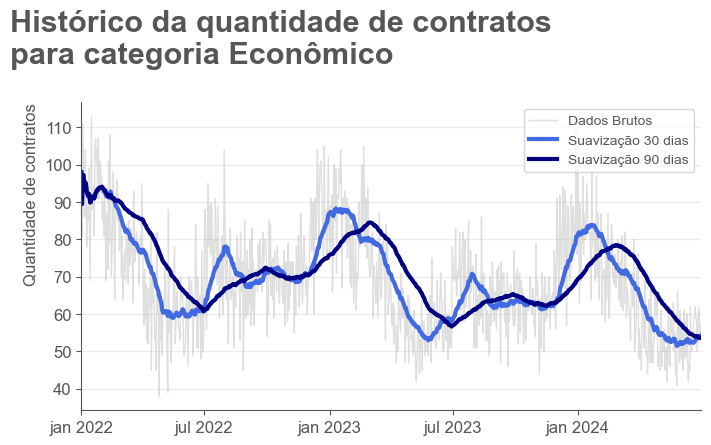

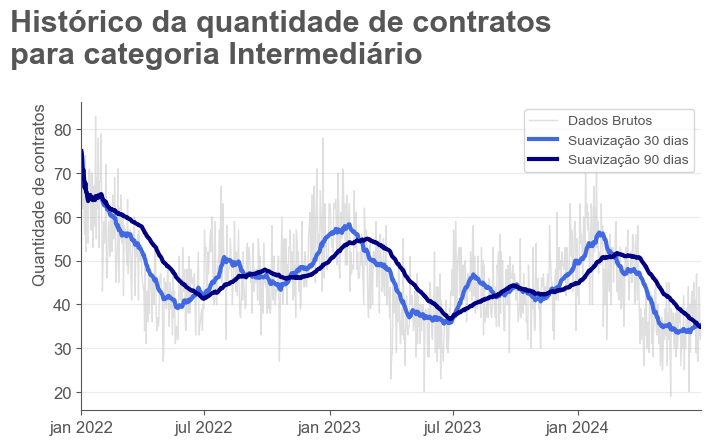

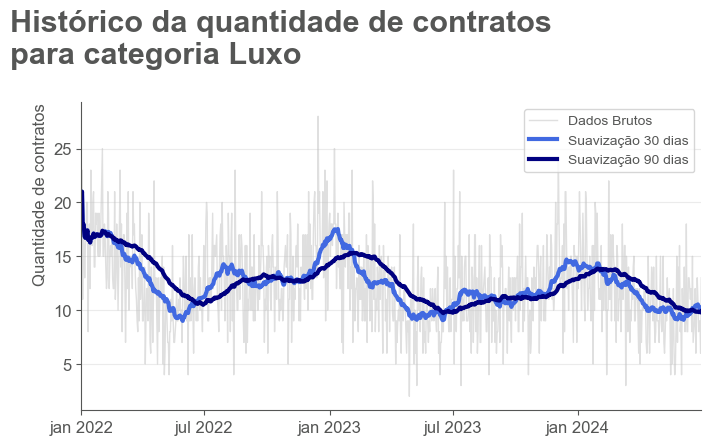

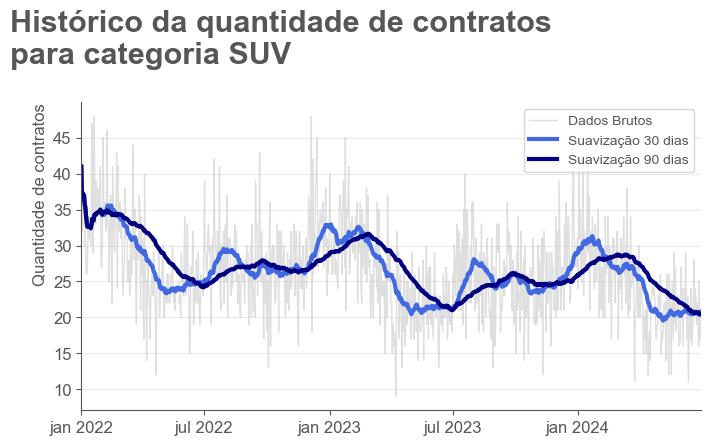

In [19]:
vehicles = sorted(df["Categoria do Veículo"].unique().tolist())

for vehicle in vehicles:
    df_temp = df.copy()
    df_temp = df_temp[df_temp["Categoria do Veículo"] == vehicle]

    time_series_plot(
        df_temp,
        title=f"Histórico da quantidade de contratos \npara categoria {vehicle}",
        column="ID do Contrato",
        y_label="Quantidade de contratos",
        filename="history of the number of contracts".replace(" ", "_"),
    )

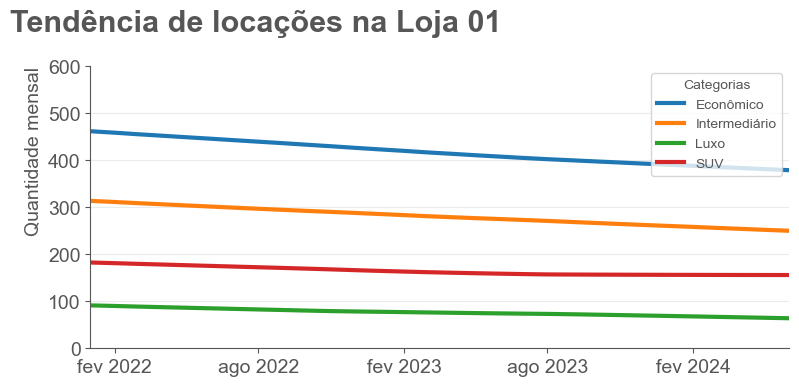

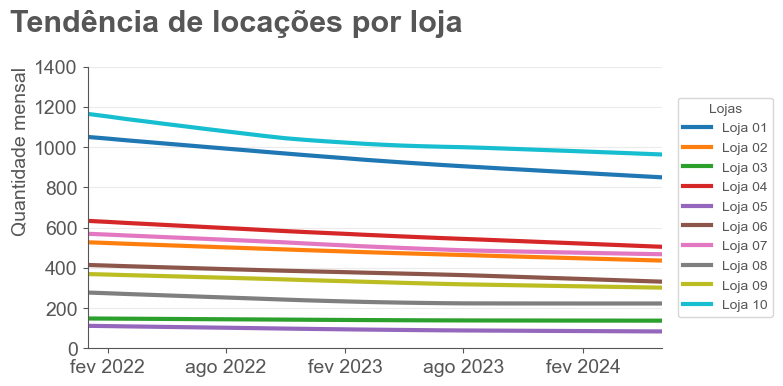

In [20]:
# Auxiliary Functions


def change_the_granularity_to_month(df: pd.DataFrame) -> pd.DataFrame:

    # Define as agregações a serem feitas
    aggregations = {
        "ID do Contrato": "count",
        "Diária Média": "mean",
        "Valor Total da Locação": "sum",
    }

    # Converte a coluna de data e cria a coluna 'mes'
    df_copy = df.copy()
    df_copy["Data de Início da Locação"] = pd.to_datetime(
        df_copy["Data de Início da Locação"]
    )
    df_copy["mes"] = df_copy["Data de Início da Locação"].dt.to_period("M")

    # Agrupa por mês, loja e categoria
    df_mensal = (
        df_copy.groupby(["mes", "ID da Loja", "Categoria do Veículo"])
        .agg(aggregations)
        .reset_index()
    )

    # Renomeia a coluna para refletir a contagem de contratos
    df_mensal = df_mensal.rename(columns={"ID do Contrato": "quantidade_contratos"})

    return df_mensal


def get_mstl_decomposition(df_single_series: pd.DataFrame, column: str):

    df_mstl = df_single_series[["mes", column]].copy()
    df_mstl["Data"] = df_mstl["mes"].dt.to_timestamp()
    df_mstl = df_mstl.set_index("Data")

    # Seleciona os períodos de sazonalidade com base no tamanho dos dados
    if len(df_mstl) >= 2 * 12:
        periods = [6, 12]
    elif len(df_mstl) >= 2 * 6:
        periods = [3, 6]
    else:
        periods = 3

    decomposition = MSTL(df_mstl[column], periods=periods).fit()

    return decomposition


def configure_trend_plot(
    ax,
    title_text,
    y_label,
    legend_title,
    min_date,
    max_date,
    y_upper_lim,
    legend_options,
    title_loc,
):
    ax.set_xlim(min_date, max_date)
    ax.set_ylim([0, int(1.1 * y_upper_lim)])

    date_format = mdates.DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.grid(axis="y", alpha=0.25)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=14, color="#555655"
    )

    leg = ax.legend(title=legend_title, labelcolor="#555655", frameon=True, **legend_options)
    leg.get_title().set_color("#555655")

    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=14, color="#555655")
    ax.text(
        *title_loc,
        title_text,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )

    ax.set_ylim([0, max(ax.get_yticks())])
    plt.tight_layout()


def plot_trends_by_category(df_monthly, stores, vehicles):

    for store in stores:
        fig, ax = plt.subplots(figsize=(8, 4))
        y_upper_lim = 0

        store_data = df_monthly[df_monthly["ID da Loja"] == store]
        if store_data.empty:
            plt.close(fig)
            continue

        min_date = store_data["mes"].min().to_timestamp()
        max_date = store_data["mes"].max().to_timestamp()

        for vehicle in vehicles:
            df_filtered = store_data[
                store_data["Categoria do Veículo"] == vehicle
            ].copy()
            if df_filtered.empty:
                continue

            decomposition = get_mstl_decomposition(df_filtered, "quantidade_contratos")
            if decomposition is None:
                continue

            sns.lineplot(data=decomposition.trend, label=vehicle, ax=ax, linewidth=3)
            y_upper_lim = max(y_upper_lim, decomposition.trend.max())

        title = f"Tendência de locações na {store.replace('LJ', 'Loja')}"
        legend_opts = {"loc": "upper right"}

        configure_trend_plot(
            ax,
            title,
            "Quantidade mensal",
            "Categorias",
            min_date,
            max_date,
            y_upper_lim,
            legend_opts,
            title_loc=(-0.115, 1.125),
        )

        plt.savefig(f"../img/results/trend_amount_{store}.png", dpi=600)

        if store != "Loja 01":
            plt.close(fig)


def plot_trends_by_store(df_monthly, stores):

    df_by_store = (
        df_monthly.groupby(["mes", "ID da Loja"])["quantidade_contratos"]
        .sum()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    y_upper_lim = 0

    min_date = df_by_store["mes"].min().to_timestamp()
    max_date = df_by_store["mes"].max().to_timestamp()

    trend_variation = dict()

    for store in stores:
        df_filtered = df_by_store[df_by_store["ID da Loja"] == store].copy()
        if df_filtered.empty:
            continue

        decomposition = get_mstl_decomposition(df_filtered, "quantidade_contratos")
        if decomposition is None:
            continue

        sns.lineplot(
            data=decomposition.trend,
            label=store.replace("LJ ", "Loja "),
            ax=ax,
            linewidth=3,
        )
        y_upper_lim = max(y_upper_lim, decomposition.trend.max())

        trend_variation[store] = [
            decomposition.trend.iloc[0],
            decomposition.trend.iloc[-1],
            (decomposition.trend.iloc[-1] - decomposition.trend.iloc[0]) / decomposition.trend.iloc[0],
        ]

    title = "Tendência de locações por loja"
    legend_opts = {"loc": "center left", "bbox_to_anchor": (1.015, 0.5)}
    configure_trend_plot(
        ax,
        title,
        "Quantidade mensal",
        "Lojas",
        min_date,
        max_date,
        y_upper_lim,
        legend_opts,
        title_loc=(-0.135, 1.125),
    )

    plt.savefig("../img/results/trend_amount.png", bbox_inches="tight", dpi=600)
    
    return trend_variation


# Execution

# Data Preparation
df_monthly = change_the_granularity_to_month(df.copy())
stores = sorted(df["ID da Loja"].unique().tolist())
vehicles = sorted(df["Categoria do Veículo"].unique().tolist())

# Graph Generation
plot_trends_by_category(df_monthly, stores, vehicles)
trend_variation = plot_trends_by_store(df_monthly, stores)

In [21]:
df_trend_variation = pd.DataFrame.from_dict(
    trend_variation,
    orient="index",
    columns=["Valor Inicial", "Valor Final", "Variação"],
)
df_trend_variation.reset_index(inplace=True)
df_trend_variation.rename(columns={"index": "Loja"}, inplace=True)

df_trend_variation["Valor Inicial"] = df_trend_variation["Valor Inicial"].round(0).astype(int)
df_trend_variation["Valor Final"] = df_trend_variation["Valor Final"].round(0).astype(int)
df_trend_variation["Variação"] = (df_trend_variation["Variação"]*100).round(2)

display(df_trend_variation)


,Loja,Valor Inicial,Valor Final,Variação
0,Loja 01,1050,849,-19.12
1,Loja 02,527,436,-17.26
2,Loja 03,148,137,-7.31
3,Loja 04,633,504,-20.35
4,Loja 05,112,84,-24.98
5,Loja 06,414,331,-20.05
6,Loja 07,569,467,-17.88
7,Loja 08,277,223,-19.65
8,Loja 09,369,301,-18.29
9,Loja 10,1165,963,-17.32


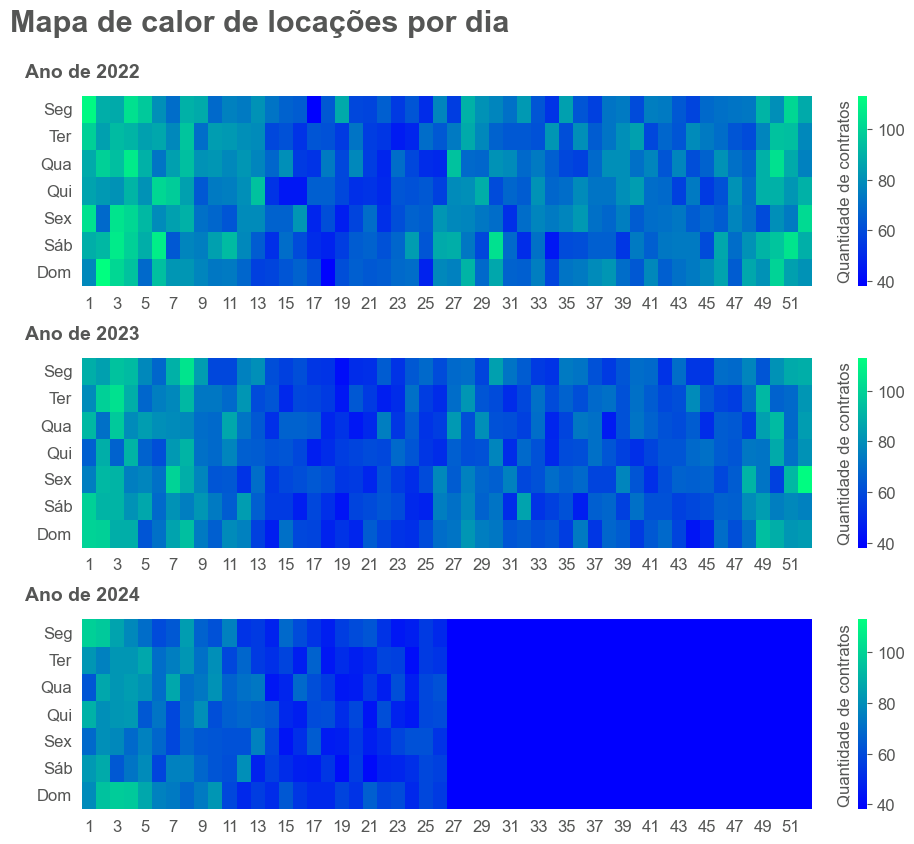

In [22]:
# Filtra Dataframe

# df_filtered = df.copy()
# df_filtered = df[df["ID da Loja"] == "Loja 05"].copy()
df_filtered = df[df["Categoria do Veículo"] == "Econômico"].copy()

# Processamento dos Dados

daily_counts = (
    df_filtered.groupby(df_filtered["Data de Início da Locação"].dt.date)
    .size()
    .reset_index(name="contagens")
)
daily_counts = daily_counts.rename(columns={"Data de Início da Locação": "data"})
daily_counts["data"] = pd.to_datetime(daily_counts["data"])

daily_counts["ano"] = daily_counts["data"].dt.year
daily_counts["semana_do_ano"] = daily_counts["data"].dt.isocalendar().week
daily_counts["dia_da_semana"] = daily_counts["data"].dt.dayofweek

vmin = daily_counts["contagens"].min()
vmax = daily_counts["contagens"].max()

anos = sorted(daily_counts["ano"].unique())

# Plot

fig, axes = plt.subplots(len(anos), 1, figsize=(10, 8), squeeze=False)

for i, ano in enumerate(anos):
    ax = axes[i, 0]
    df_year = daily_counts[daily_counts["ano"] == ano]

    # Cria a matriz (pivot table) para o heatmap
    # Linhas: dia da semana, Colunas: semana do ano, Valores: contagem de contratos
    heatmap_data = df_year.pivot_table(
        index="dia_da_semana",
        columns="semana_do_ano",
        values="contagens",
        fill_value=0,  # Preenche dias sem locações com 0
    )

    # Garante que todas as semanas (1-53) e dias (0-6) estejam presentes na matriz
    heatmap_data = heatmap_data.reindex(
        index=range(7), columns=range(1, 53), fill_value=0
    )

    # Desenha o mapa de calor usando os limites globais vmin e vmax
    cbar = sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap="winter",
        linewidths=0,
        vmin=vmin,
        vmax=vmax,
    )

    # Configurações do Plot

    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )
    ax.tick_params(left=False, bottom=False)

    cbar = cbar.collections[0].colorbar
    cbar.set_label("Quantidade de contratos", size=12, color="#555655")
    cbar.ax.yaxis.set_label_position("left")
    cbar.ax.tick_params(labelsize=12, colors="#555655")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(
        0.0,
        1.1,
        f"Ano de {ano}",
        transform=ax.transAxes,
        fontsize=14,
        fontweight="semibold",
        color="#555655",
        ha="center",
    )

    dias_semana_labels = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
    ax.set_yticklabels(dias_semana_labels, rotation=0)

fig.text(
    0.25,
    1.05,
    "Mapa de calor de locações por dia",
    ha="center",
    va="top",
    fontsize=22,
    fontweight="semibold",
    color="#555655",
)

plt.tight_layout()

plt.savefig("../img/results/heat_map.png", dpi=600, bbox_inches="tight")

### Perguntas Chaves

* **Como o negócio se comporta YoY (Year over Year)?** Houve uma queda de 5,71% no valor do ticket médio.

* **Qual o perfil de sazonalidade do negócio?** Demonstrar o perfil de locação (é esperado o maior volume em épocas de férias escolares, isto é, final/começo do ano e meio do ano, principalmente no primeiro período). Comparar entre as diferentes lojas e categorias de veículos.

* **Existe algum dia da semana com maior percentual de locação?**

* **Existe algum feriado com maior percentual de locação?**

* **Qual a tendência do volume de contratos?** Comparar entre as diferentes lojas e categorias de veículos.

* **Existe diferença histórica das demais métricas?** Avaliar o histórico das demais métricas, além do volume de contratos.

Fazer comparações para as lojas top 3 piores performances (5, 3 e 8) e top 1 melhor performance (10). Além das top 3 maiores tendências de queda (5, 4 e 6) e top 1 menor tendência de queda (3).


**Feriados obrigatórios no Brasil**

* *01 de janeiro*: Confraternização Universal
* *30 de março*: Paixão de Cristo (data conforme calendário 2018)
* *21 de abril*: Tiradentes
* *1 de maio*: Dia Mundial do Trabalho
* *7 de setembro*: Independência do Brasil
* *12 de outubro*: Nossa Senhora Aparecida
* *2 de novembro*: Finados
* *15 de novembro*: Proclamação da República
* *25 de dezembro*: Natal

In [23]:
df_temp = df.copy()
df_temp["Data de Início da Locação"] = pd.to_datetime(
    df_temp["Data de Início da Locação"]
)
df_temp["Ano"] = df_temp["Data de Início da Locação"].dt.year
df_temp["Ticket Médio"] = df_temp["Valor Total da Locação"]
df_temp = df_temp.groupby("Ano").agg({"Ticket Médio": "mean"})
df_temp["Ticket Médio"] = df_temp["Ticket Médio"].round(0).astype(int)
display(df_temp)

average_ticket = df_temp["Ticket Médio"].values
print(
    f"Houve uma queda de {(average_ticket[0]-average_ticket[-1])*100/average_ticket[0]:.2f}% no valor do ticket médio."
)

,Ticket Médio
Ano,
2022,770
2023,770
2024,726


Houve uma queda de 5.71% no valor do ticket médio.


In [24]:
df_temp = df.copy()
df_temp["Data de Início da Locação"] = pd.to_datetime(
    df_temp["Data de Início da Locação"]
)
df_temp["Dia da Semana"] = df_temp["Data de Início da Locação"].dt.dayofweek
df_temp["Ticket Médio"] = df_temp["Valor Total da Locação"]
df_temp = df_temp.groupby("Dia da Semana").agg(
    {
        "ID do Contrato": "count",
        "Ticket Médio": "mean",
        "Valor Total da Locação": "sum",
        "Duração da Locação": "mean",
    }
)
df_temp.rename(columns={"ID do Contrato": "Quantidade de Contratos"}, inplace=True)
df_temp["Ticket Médio"] = df_temp["Ticket Médio"].round(2)
df_temp["Duração da Locação"] = df_temp["Duração da Locação"].round(0).astype(int)

display(df_temp)

# 0: Segunda
# 1: Terça
# 2: Quarta
# 3: Quinta
# 4: Sexta
# 5: Sábado
# 6: Domingo

,Quantidade de Contratos,Ticket Médio,Valor Total da Locação,Duração da Locação
Dia da Semana,,,,
0,20134,761.48,15331723.08,6
1,19828,761.89,15106834.91,6
2,20279,754.31,15296593.58,6
3,19585,758.91,14863272.00,6
4,19904,760.40,15135062.35,6
5,20106,768.94,15460277.19,6
6,20413,767.60,15669041.34,6


In [25]:
df_temp = df.copy()

df_temp["Data de Início da Locação"] = pd.to_datetime(
    df_temp["Data de Início da Locação"]
)
df_temp = df_temp[
    df_temp["Data de Início da Locação"] < datetime(year=2024, month=1, day=1)
]
df_temp["Ticket Médio"] = df_temp["Valor Total da Locação"]

df_temp["Dia"] = df_temp["Data de Início da Locação"].dt.day
df_temp["Mês"] = df_temp["Data de Início da Locação"].dt.month

df_temp = df_temp.groupby(["Dia", "Mês"]).agg(
    {
        "ID do Contrato": "count",
        "Ticket Médio": "mean",
        "Valor Total da Locação": "sum",
        "Duração da Locação": "mean",
    }
)
df_temp.rename(columns={"ID do Contrato": "Quantidade de Contratos"}, inplace=True)
df_temp["Valor Total da Locação"] = df_temp["Valor Total da Locação"].round(2)
df_temp["Ticket Médio"] = df_temp["Ticket Médio"].round(2)
df_temp["Duração da Locação"] = df_temp["Duração da Locação"].round(0).astype(int)

display(df_temp)

"""
* 01 de janeiro: Confraternização Universal
* 30 de março: Paixão de Cristo (data conforme calendário 2018)
* 21 de abril: Tiradentes
* 1 de maio: Dia Mundial do Trabalho
* 7 de setembro: Independência do Brasil
* 12 de outubro: Nossa Senhora Aparecida
* 2 de novembro: Finados
* 15 de novembro: Proclamação da República
* 25 de dezembro: Natal
"""

Quantidade de Contratos  Ticket Médio  Valor Total da Locação  \
Dia Mês                                                                  
1   1                        431        968.97               417626.92   
    2                        366        707.42               258916.29   
    3                        340        761.72               258983.80   
    4                        287        571.99               164161.88   
    5                        242        595.76               144174.70   
...                          ...           ...                     ...   
31  5                        273        616.82               168391.41   
    7                        350        880.41               308144.33   
    8                        272        746.57               203065.98   
    10                       321        740.91               237830.84   
    12                       371        924.97               343164.99   

         Duração da Locação  
Dia Mês                      
1   1                     8  
    2                     6  
    3                     6  
    4                     5  
    5                     5  
...                     ...  
31  5                     5  
    7                     7  
    8                     6  
    10                    6  
    12                    8  

[365 rows x 4 columns]

'\n* 01 de janeiro: Confraternização Universal\n* 30 de março: Paixão de Cristo (data conforme calendário 2018)\n* 21 de abril: Tiradentes\n* 1 de maio: Dia Mundial do Trabalho\n* 7 de setembro: Independência do Brasil\n* 12 de outubro: Nossa Senhora Aparecida\n* 2 de novembro: Finados\n* 15 de novembro: Proclamação da República\n* 25 de dezembro: Natal\n'

### Análise Preditiva

#### ARIMA

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=121.145, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=123.319, Time=0.12 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=117.379, Time=0.02 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=118.832, Time=0.15 sec
 ARIMA(2,2,0)(0,1,0)[12]             : AIC=119.379, Time=0.03 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=119.378, Time=0.05 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=118.492, Time=0.03 sec
 ARIMA(2,2,1)(0,1,0)[12]             : AIC=121.033, Time=0.05 sec
 ARIMA(1,2,0)(0,1,0)[12] intercept   : AIC=118.390, Time=

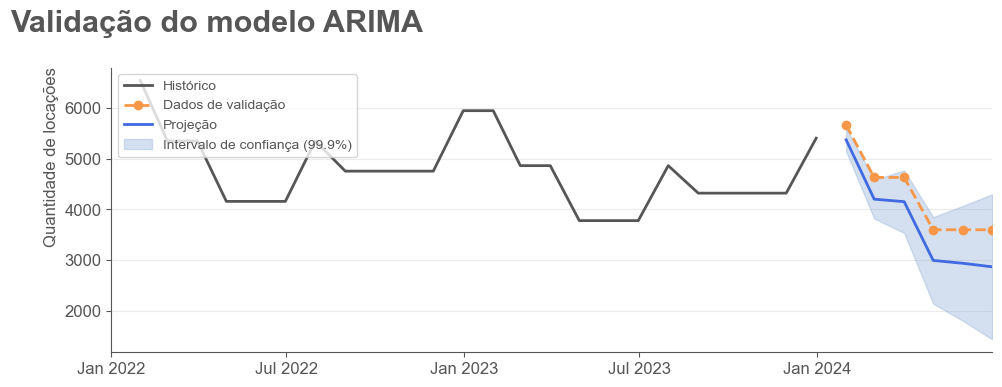

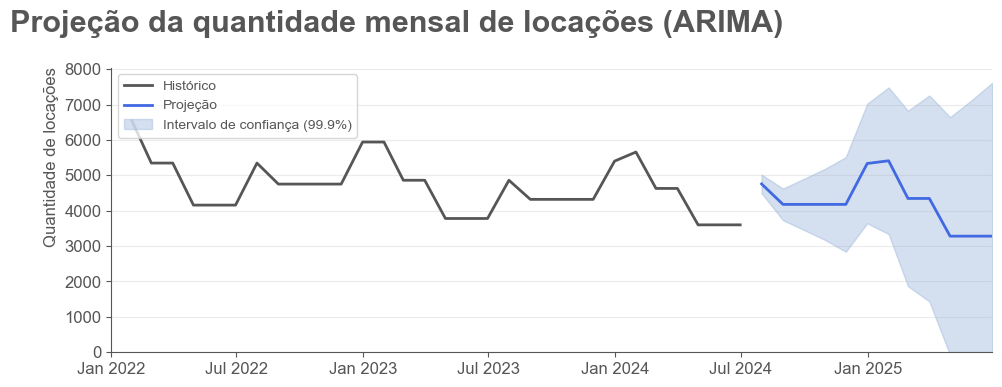

In [59]:
# Auxiliary Functions


def validation_arima(
    y,
    test_size=6,
    m=12,
    alpha=0.05,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    start_P=0,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
):
    """
    Realiza o treinamento, validação e avaliação de um modelo auto_arima para
    séries temporais.

    Args:
        y (pd.Series): Series com a variável alvo.
        test_size (int): Número de amostras a serem usadas como conjunto de teste.
        m (int): O ciclo sazonal do auto_arima (e.g., 12 para dados mensais).
        start_p (int): Ordem inicial do termo auto-regressivo (p).
        start_q (int): Ordem inicial do termo de média móvel (q).
        max_p (int): Ordem máxima do termo auto-regressivo (p).
        max_q (int): Ordem máxima do termo de média móvel (q).
        start_P (int): Ordem inicial do termo auto-regressivo sazonal (P).
        D (int): Ordem da diferenciação sazonal (D).
        trace (bool): Se True, exibe o log de auto_arima.
        error_action (str): Ação a ser tomada em caso de erro.
        suppress_warnings (bool): Se True, suprime os warnings.
        stepwise (bool): Se True, utiliza o método stepwise para busca.

    Returns:
        tuple: Uma tupla contendo:
            - y_train (pd.Series): Dados de treino da variável alvo.
            - y_test (pd.Series): Dados de teste da variável alvo.
            - y_pred (np.array): Previsões do modelo para o conjunto de teste.
            - lower_bound (np.array): Limite inferior do intervalo de confiança.
            - upper_bound (np.array): Limite superior do intervalo de confiança.
    """
    # Divisão dos dados em treino e teste
    y_train, y_test = y[:-test_size], y[-test_size:]

    # Treinamento do modelo
    best_model = pm.auto_arima(
        y_train,
        start_p=start_p,
        start_q=start_q,
        test="adf",
        max_p=max_p,
        max_q=max_q,
        m=m,
        d=None,
        seasonal=True,
        start_P=start_P,
        D=D,
        trace=trace,
        error_action=error_action,
        suppress_warnings=suppress_warnings,
        stepwise=stepwise,
    )
    print("\n--- Sumário do Modelo auto_arima ---")
    print(best_model.summary())

    # Previsões no período de teste
    y_pred, conf_int_test = best_model.predict(
        n_periods=len(y_test),
        return_conf_int=True,
        alpha=alpha,
    )

    lower_bound = conf_int_test[:, 0]
    upper_bound = conf_int_test[:, 1]

    # Cálculo e exibição das métricas de avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

    print("\n--- Métricas de Avaliação do Modelo (período de teste) ---")
    print(f"MAE (Erro Absoluto Médio): {mae:.2f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
    print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

    return y_train, y_test, y_pred, lower_bound, upper_bound


def model_arima(
    y,
    n_periods_future,
    alpha=0.05,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
):
    """
    Treina o modelo auto_arima.

    Args:
        y (pd.Series): Series completa com todos os dados históricos.
        n_periods_future (int): Número de períodos no futuro para a projeção.
        start_p (int): Ordem inicial do termo auto-regressivo (p).
        start_q (int): Ordem inicial do termo de média móvel (q).
        max_p (int): Ordem máxima do termo auto-regressivo (p).
        max_q (int): Ordem máxima do termo de média móvel (q).
        m (int): O ciclo sazonal (e.g., 12 para dados mensais).
        start_P (int): Ordem inicial do termo auto-regressivo sazonal (P).
        D (int): Ordem da diferenciação sazonal (D).
        trace (bool): Se True, exibe o log de auto_arima.
        error_action (str): Ação a ser tomada em caso de erro.
        suppress_warnings (bool): Se True, suprime os warnings.
        stepwise (bool): Se True, utiliza o método stepwise para busca.

    Returns:
        tuple: Uma tupla contendo:
            - X_pred (pd.DatetimeIndex): Datas futuras da projeção.
            - y_pred (np.array): A projeção dos valores futuros.
            - lower_bound_future (np.array): Limite inferior do intervalo de confiança futuro.
            - upper_bound_future (np.array): Limite superior do intervalo de confiança futuro.
    """
    final_model = pm.auto_arima(
        y,
        start_p=start_p,
        start_q=start_q,
        test="adf",
        max_p=max_p,
        max_q=max_q,
        m=m,
        d=None,
        seasonal=True,
        start_P=start_P,
        D=D,
        trace=trace,
        error_action=error_action,
        suppress_warnings=suppress_warnings,
        stepwise=stepwise,
    )

    print("\n--- Sumário do Modelo Final auto_arima ---")
    print(final_model.summary())

    # Projeção dos valores e cálculo do intervalo de confiança
    y_pred, conf_int_future = final_model.predict(
        n_periods=n_periods_future, return_conf_int=True, alpha=alpha
    )

    lower_bound_future = conf_int_future[:, 0]
    upper_bound_future = conf_int_future[:, 1]

    # Geração das datas futuras
    X_pred = pd.date_range(
        start=y.index[-1] + pd.DateOffset(months=1),
        periods=n_periods_future,
        freq="ME",
    )

    return (
        X_pred,
        y_pred,
        lower_bound_future,
        upper_bound_future,
    )


def config_prediction_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper left", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )
    plt.tight_layout()


def validation_arima_plot(
    y_train, y_test, y_pred, lower_bound, upper_bound, min_date, max_date, alpha=0.05
):
    """
    Gera e salva o gráfico de validação do modelo ARIMA.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(y_train.index, y_train, label="Histórico", color="#555655", linewidth=2)
    ax.plot(
        y_test.index,
        y_test,
        label="Dados de validação",
        color="#F79747",
        marker="o",
        linestyle="--",
        linewidth=2,
    )
    ax.plot(
        y_test.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    conf_level_percent = (1 - alpha) * 100
    ax.fill_between(
        y_test.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label=f"Intervalo de confiança ({conf_level_percent:.1f}%)",
    )

    config_prediction_plot(
        ax,
        title="Validação do modelo ARIMA",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig("../img/results/validation_arima.png", dpi=600, bbox_inches="tight")


def model_arima_plot(
    y,
    X_pred,
    y_pred,
    lower_bound_future,
    upper_bound_future,
    min_date,
    title,
    y_label,
    alpha=0.05,
):
    """
    Gera o gráfico com os dados históricos e a projeção futura do modelo SARIMA.

    Args:
        y (pd.Series): Série com os dados históricos.
        X_pred (pd.DatetimeIndex): Datas futuras da projeção.
        y_pred (np.array): Projeções para o futuro.
        lower_bound_future (np.array): Limite inferior do intervalo de confiança.
        upper_bound_future (np.array): Limite superior do intervalo de confiança.
    """
    max_date = X_pred.max()

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        y.index,
        y,
        label="Histórico",
        color="#555655",
        linewidth=2,
    )
    ax.plot(
        X_pred,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    conf_level_percent = (1 - alpha) * 100
    ax.fill_between(
        X_pred,
        lower_bound_future,
        upper_bound_future,
        color="#94B2D7",
        alpha=0.4,
        label=f"Intervalo de confiança ({conf_level_percent:.1f}%)",
    )

    config_prediction_plot(
        ax,
        title=title,
        y_label=y_label,
        min_date=min_date,
        max_date=max_date,
    )

    if y_label != "Quantidade de locações":
        plt.close(fig)
    else:
        plt.ylim(bottom=0)
        fig.savefig(
            "../img/results/prediction_amount_arima.png",
            dpi=600,
            bbox_inches="tight",
        )


# Execution

# Preparação dos Dados

df["Data de Início da Locação"] = pd.to_datetime(df["Data de Início da Locação"])
min_date = df["Data de Início da Locação"].min()
max_date = df["Data de Início da Locação"].max()

df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"ID do Contrato": "count"})
    .rename(columns={"ID do Contrato": "Quantidade_Locacoes"})
)

y = df_monthly["Quantidade_Locacoes"]

alpha = 1 - 0.999

# Validação do Modelo com auto_arima

y_train, y_test, y_pred, lower_bound, upper_bound = validation_arima(y=y, alpha=alpha)
validation_arima_plot(
    y_train, y_test, y_pred, lower_bound, upper_bound, min_date, max_date, alpha
)

# Projeção (Quantidade)

X_pred, y_pred, lower_bound_future, upper_bound_future = model_arima(
    y=y, n_periods_future=12, alpha=alpha
)

title = "Projeção da quantidade mensal de locações (ARIMA)"
y_label = "Quantidade de locações"
model_arima_plot(
    y,
    X_pred,
    y_pred,
    lower_bound_future,
    upper_bound_future,
    min_date,
    title,
    y_label,
    alpha,
)

print(f"{y_label}:")
print(y_pred)

# Projeção (Valor Total)

df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"Valor Total da Locação": "sum"})
)

y = df_monthly["Valor Total da Locação"]

X_pred, y_pred, lower_bound_future, upper_bound_future = model_arima(
    y=y, n_periods_future=12, alpha=alpha
)

title = "Projeção do valor total mensal de locações (ARIMA)"
y_label = "Valor total (R$)"
model_arima_plot(
    y,
    X_pred,
    y_pred,
    lower_bound_future,
    upper_bound_future,
    min_date,
    title,
    y_label,
    alpha,
)

print(f"\n{y_label}:")
print(y_pred)

# Projeção (Ticket Médio)

df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"Valor Total da Locação": "mean"})
    .rename(columns={"Valor Total da Locação": "Ticket Médio"})
)

y = df_monthly["Ticket Médio"]

X_pred, y_pred, lower_bound_future, upper_bound_future = model_arima(
    y=y, n_periods_future=12, alpha=alpha
)

title = "Projeção do ticket médio mensal de locações (ARIMA)"
y_label = "Ticket médio (R$)"
model_arima_plot(
    y,
    X_pred,
    y_pred,
    lower_bound_future,
    upper_bound_future,
    min_date,
    title,
    y_label,
    alpha,
)

print(f"\n{y_label}:")
print(y_pred)

#### XGBoost

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=400, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=400, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rat

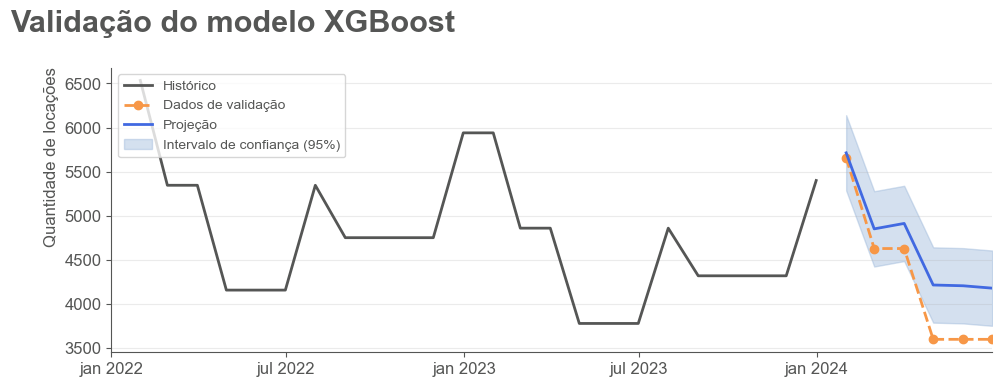

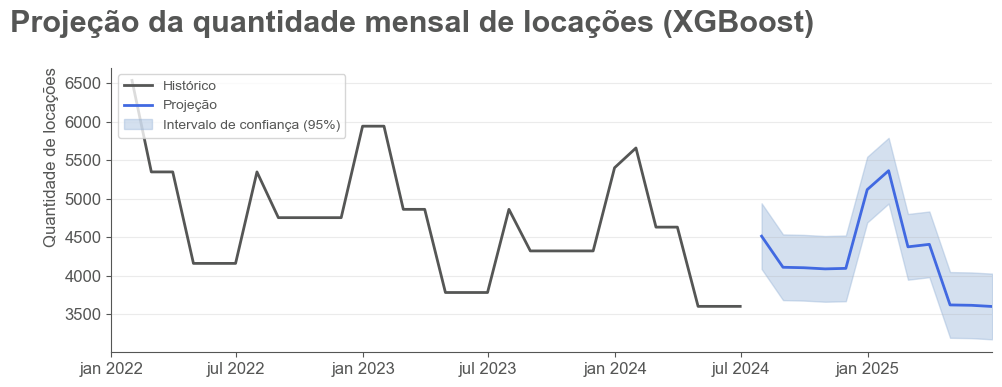

In [28]:
# warnings.filterwarnings("ignore", module="xgboost")

# Auxiliary Functions


def validation_xgboost(X, y, param_grid, test_size=6, random_state=42):
    """
    Realiza o treinamento e avaliação de um modelo XGBoost com GridSearchCV.
    """
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    # Instanciação e configuração do GridSearchCV
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_state
    )
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2,
        scoring="neg_mean_squared_error",
    )

    # Treinamento do modelo
    grid_search.fit(X_train, y_train)
    best_xgb = grid_search.best_estimator_
    print("\nMelhores parâmetros encontrados:", grid_search.best_params_)

    # Projeção e avaliação no conjunto de teste
    y_pred = grid_search.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

    print("\nMétricas de Avaliação do Modelo XGBoost (período de teste):")
    print(f"  - MAE (Erro Absoluto Médio): {mae:.2f}")
    print(f"  - RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
    print(f"  - MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

    # Cálculo do intervalo de confiança
    residuals = y_test - y_pred
    interval = 1.96 * np.std(residuals)
    lower_bound = y_pred - interval
    upper_bound = y_pred + interval

    return (
        X_train,
        X_test,
        y_train,
        y_test,
        y_pred,
        best_xgb,
        interval,
        lower_bound,
        upper_bound,
    )


def model_xgboost(
    X, y, best_params, interval, start_date="2024-07-01", end_date="2025-06-30"
):
    """
    Treina o modelo XGBoost final com todos os dados e projeta valores futuros.
    """
    # Treinamento do modelo final com todos os dados
    full_model = xgb.XGBRegressor(**best_params.get_params())
    full_model.fit(X, y)

    # Criação do DataFrame e features para o período futuro
    future_dates = pd.date_range(start=start_date, end=end_date, freq="ME")
    X_pred = pd.DataFrame(index=future_dates)

    X_pred["time_index"] = np.arange(
        len(df_monthly), len(df_monthly) + len(future_dates)
    )
    X_pred["month"] = X_pred.index.month
    X_pred["year"] = X_pred.index.year

    # Projeção dos valores
    y_pred = full_model.predict(X_pred[["time_index", "month", "year"]])

    # Cálculo do intervalo de confiança para a projeção
    lower_bound_future = y_pred - interval
    upper_bound_future = y_pred + interval

    return X_pred, y_pred, lower_bound_future, upper_bound_future


def config_prediction_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper left", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )
    plt.tight_layout()


def validation_xgboost_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
):
    """
    Gera e salva o gráfico de validação do modelo.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(X_train.index, y_train, label="Histórico", color="#555655", linewidth=2)
    ax.plot(
        X_test.index,
        y_test,
        label="Dados de validação",
        color="#F79747",
        marker="o",
        linestyle="--",
        linewidth=2,
    )
    ax.plot(
        X_test.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        X_test.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Validação do modelo XGBoost",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig("../img/results/validation_xgboost.png", dpi=600, bbox_inches="tight")


def model_xgboost_plot(X, y, X_pred, y_pred, lower_bound, upper_bound, min_date):
    """
    Gera e exibe o gráfico com os dados históricos e a projeção futura.
    """
    max_date = X_pred.index.max()

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        X.index,
        y,
        label="Histórico",
        color="#555655",
        linewidth=2,
    )
    ax.plot(
        X_pred.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        X_pred.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Projeção da quantidade mensal de locações (XGBoost)",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig(
        "../img/results/prediction_amount_xgboost.png", dpi=600, bbox_inches="tight"
    )


# Execution
# Preparação e Engenharia de Atributos

df["Data de Início da Locação"] = pd.to_datetime(df["Data de Início da Locação"])
min_date = df["Data de Início da Locação"].min()
max_date = df["Data de Início da Locação"].max()

# Mudança da escala/granulidade do conjunto de dados
df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"ID do Contrato": "count"})
    .rename(columns={"ID do Contrato": "Quantidade_Locacoes"})
)

# Criação dos atributos a partir do índice de data
df_monthly["time_index"] = np.arange(len(df_monthly))  # Tendência temporal
df_monthly["month"] = df_monthly.index.month  # Sazonalidade mensal
df_monthly["year"] = df_monthly.index.year  # Sazonalidade anual

# Definição das variáveis preditoras (X) e alvo (y)
X = df_monthly[["time_index", "month", "year"]]
y = df_monthly["Quantidade_Locacoes"]

# Treinamento e Validação do Modelo com XGBoost e GridSearchCV

param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [400, 500, 600],
    'min_child_weight': [1, 2],
    'gamma': [0.0, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    best_xgb,
    interval,
    lower_bound,
    upper_bound,
) = validation_xgboost(X, y, param_grid)
validation_xgboost_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
)

# Projeção

X_pred, y_pred, lower_bound_future, upper_bound_future = model_xgboost(
    X, y, best_xgb, interval
)
model_xgboost_plot(
    X, y, X_pred, y_pred, lower_bound_future, upper_bound_future, min_date
)

#### Linear Model


Métricas de Avaliação do Linear Model:
  - MAE (Erro Absoluto Médio): 635.28
  - RMSE (Raiz do Erro Quadrático Médio): 720.48
  - MAPE (Erro Percentual Absoluto Médio): 14.49%


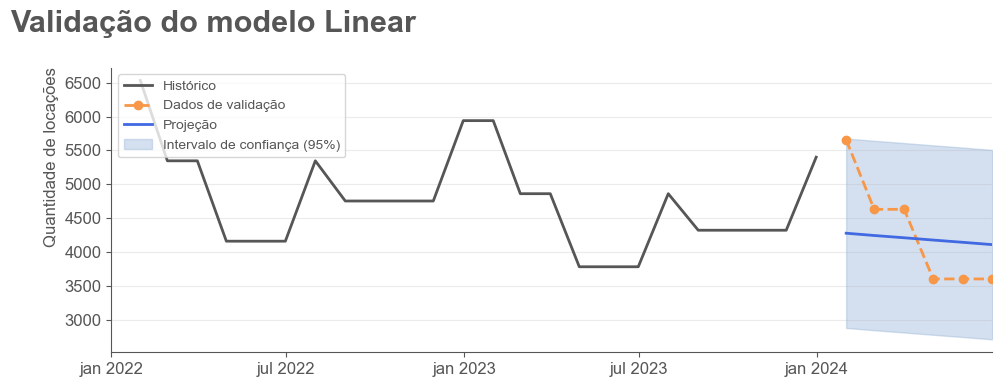

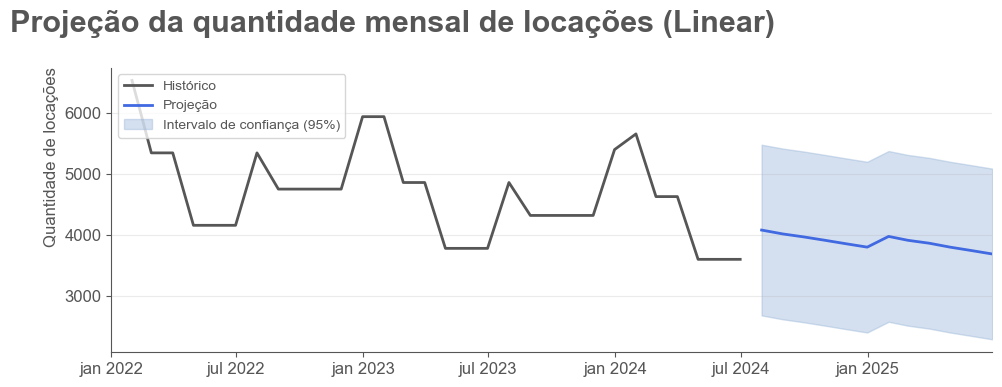

In [29]:
# Auxiliary Functions


def validation_linear(X, y, test_size=6):
    """
    Realiza o treinamento e avaliação de um modelo de Regressão Linear.
    """
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    # Treinamento do modelo de Regressão Linear
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Projeção no conjunto de teste
    y_pred = lr_model.predict(X_test)

    # Métricas de avaliação do modelo
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

    print("\nMétricas de Avaliação do Linear Model:")
    print(f"  - MAE (Erro Absoluto Médio): {mae:.2f}")
    print(f"  - RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
    print(f"  - MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

    # Cálculo do intervalo de confiança
    residuals = y_test - y_pred
    interval = 1.96 * np.std(residuals)
    lower_bound = y_pred - interval
    upper_bound = y_pred + interval

    return X_train, X_test, y_train, y_test, y_pred, interval, lower_bound, upper_bound


def model_linear(X, y, interval, start_date="2024-07-01", end_date="2025-06-30"):
    """
    Corrige a projeção.
    """
    # Treinamento do modelo com todos os dados históricos
    full_model = LinearRegression()
    full_model.fit(X, y)

    # Criação das datas futuras para a projeção
    future_dates = pd.date_range(start=start_date, end=end_date, freq="ME")
    future_df = pd.DataFrame(index=future_dates)

    future_df["time_index"] = np.arange(len(X), len(X) + len(future_dates))
    future_df["month"] = future_df.index.month
    future_df["year"] = future_df.index.year

    # Projeção
    future_projection = full_model.predict(future_df[["time_index", "month", "year"]])
    future_df["projection"] = future_projection

    # Cálculo do intervalo de confiança para a projeção
    lower_bound_future = future_projection - interval
    upper_bound_future = future_projection + interval

    return future_df, lower_bound_future, upper_bound_future


def config_prediction_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper left", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )
    plt.tight_layout()


def validation_linear_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
):
    """
    Gera e salva o gráfico de validação do modelo.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        X_train.index, y_train, label="Histórico", color="#555655", linewidth=2
    )
    ax.plot(
        X_test.index,
        y_test,
        label="Dados de validação",
        color="#F79747",
        marker="o",
        linestyle="--",
        linewidth=2,
    )
    ax.plot(
        X_test.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        y_test.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Validação do modelo Linear",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig("../img/results/validation_linear.png", dpi=600, bbox_inches="tight")


def model_linear_plot(X, y, future_df, lower_bound, upper_bound, min_date):
    """
    Gera e salva o gráfico de projeção do modelo.
    """
    max_date = future_df.index.max()

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        X.index,
        y,
        label="Histórico",
        color="#555655",
        linewidth=2,
    )
    ax.plot(
        future_df.index,
        future_df["projection"],
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        future_df.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Projeção da quantidade mensal de locações (Linear)",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig(
        "../img/results/prediction_amount_linear.png", dpi=600, bbox_inches="tight"
    )


# Execution
# Preparação e Engenharia de Atributos

df["Data de Início da Locação"] = pd.to_datetime(df["Data de Início da Locação"])
min_date = df["Data de Início da Locação"].min()
max_date = df["Data de Início da Locação"].max()

# Mudança da escala/granulidade do conjunto de dados
df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"ID do Contrato": "count"})
    .rename(columns={"ID do Contrato": "Quantidade_Locacoes"})
)

# Criação dos atributos a partir do índice de data
df_monthly["time_index"] = np.arange(len(df_monthly))  # Tendência temporal
df_monthly["month"] = df_monthly.index.month  # Sazonalidade mensal
df_monthly["year"] = df_monthly.index.year  # Sazonalidade anual

# Definição das variáveis preditoras (X) e alvo (y)
X = df_monthly[["time_index", "month", "year"]]
y = df_monthly["Quantidade_Locacoes"]

# Treinamento e Validação do Modelo

X_train, X_test, y_train, y_test, y_pred, interval, lower_bound, upper_bound = (
    validation_linear(X, y, test_size=6)
)
validation_linear_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
)

# Projeção

future_df, lower_bound_future, upper_bound_future = model_linear(X, y, interval)
model_linear_plot(X, y, future_df, lower_bound_future, upper_bound_future, min_date)

#### Random Forest

In [30]:
# # Auxiliary Functions


# def prediction_interval(model, X_data):
#     """
#     Calcula o intervalo de confiança de 95% para as previsões de um modelo
#     Random Forest a partir das predições de cada árvore individual.

#     Args:
#         model (RandomForestRegressor): O modelo Random Forest treinado.
#         X_data (pd.DataFrame): Os dados de entrada para os quais a predição será feita.

#     Returns:
#         tuple: Uma tupla contendo o limite inferior e o limite superior do intervalo.
#     """
#     preds = np.array([tree.predict(X_data) for tree in model.estimators_])
#     lower = np.percentile(preds, 2.5, axis=0)
#     upper = np.percentile(preds, 97.5, axis=0)

#     return lower, upper


# def validation_randomforest(X, y, param_grid, test_size=6, random_state=42):
#     """
#     Realiza o treinamento e avalidação (com GridSearchCV) de um modelo
#     Random Forest para séries temporais.
#     """
#     # Divisão dos dados em treino e teste, mantendo a ordem temporal
#     X_train, X_test = X[:-test_size], X[-test_size:]
#     y_train, y_test = y[:-test_size], y[-test_size:]

#     # Validação cruzada específica para séries temporais
#     tscv = TimeSeriesSplit(n_splits=5)

#     # Configuração e execução do Grid Search
#     grid_search = GridSearchCV(
#         estimator=RandomForestRegressor(random_state=random_state),
#         param_grid=param_grid,
#         cv=tscv,
#         scoring="neg_mean_squared_error",
#         n_jobs=-1,
#         verbose=1,
#     )
#     grid_search.fit(X_train, y_train)

#     # Melhor modelo encontrado
#     best_model = grid_search.best_estimator_
#     print(f"\nMelhores parâmetros encontrados: {best_model}")

#     # Projeção e cálculo do intervalo de confiança no conjunto de teste
#     y_pred = best_model.predict(X_test)
#     lower_bound, upper_bound = prediction_interval(best_model, X_test)

#     # Cálculo e exibição das métricas de avaliação
#     mae = mean_absolute_error(y_test, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

#     print("\nMétricas de Avaliação do Modelo Random Forest (período de teste)")
#     print(f"MAE (Erro Absoluto Médio): {mae:.2f}")
#     print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
#     print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

#     return (
#         X_train,
#         X_test,
#         y_train,
#         y_test,
#         y_pred,
#         best_model,
#         lower_bound,
#         upper_bound
#     )


# def model_randomforest(
#     X, y, best_params, start_date="2024-07-01", end_date="2025-06-30"
# ):
#     """
#     Treina o modelo final com todos os dados e projeta valores futuros.
#     """
#     # Treinamento do modelo final com todos os dados
#     final_model = RandomForestRegressor(**best_params.get_params())
#     final_model.fit(X, y)

#     # Criação das datas e features para o período futuro
#     future_dates = pd.date_range(start=start_date, end=end_date, freq="ME")
#     X_pred = pd.DataFrame(index=future_dates)
#     X_pred["time_index"] = np.arange(len(X), len(X) + len(future_dates))
#     X_pred["month"] = X_pred.index.month
#     X_pred["year"] = X_pred.index.year

#     # Projeção dos valores e cálculo do intervalo de confiança
#     y_pred = final_model.predict(X_pred)
#     lower_bound_future, upper_bound_future = prediction_interval(final_model, X_pred)

#     return X_pred, y_pred, lower_bound_future, upper_bound_future


# def config_prediction_plot(ax, title: str, y_label: str, min_date, max_date):
#     """
#     Aplica uma configuração de estilo específica a um eixo Matplotlib.
#     """
#     # Define os limites do eixo X e o formato das datas
#     ax.set_xlim(min_date, max_date)
#     date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
#     ax.xaxis.set_major_formatter(date_format)
#     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

#     # Estiliza os ticks e as bordas (spines) do gráfico
#     ax.tick_params(color="#555655")
#     ax.spines["bottom"].set_color("#555655")
#     ax.spines["left"].set_color("#555655")
#     ax.spines["right"].set_visible(False)
#     ax.spines["top"].set_visible(False)

#     # Configura o grid
#     ax.grid(True, axis="y", alpha=0.25)
#     ax.xaxis.grid(False)

#     # Estiliza os rótulos dos ticks (números nos eixos)
#     plt.setp(
#         [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
#     )

#     # Configura os rótulos dos eixos e a legenda
#     ax.set_xlabel("")
#     ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
#     ax.legend(title="", labelcolor="#555655", loc="upper left", frameon=True)

#     # Adiciona o título principal com posicionamento customizado
#     ax.text(
#         -0.115,
#         1.125,
#         title,
#         transform=ax.transAxes,
#         fontsize=22,
#         fontweight="semibold",
#         color="#555655",
#     )
#     plt.tight_layout()


# def validation_randomforest_plot(
#     X_train,
#     X_test,
#     y_train,
#     y_test,
#     y_pred,
#     lower_bound,
#     upper_bound,
#     min_date,
#     max_date,
# ):
#     """
#     Gera o gráfico de validação comparando dados reais, projeções e
#     intervalo de confiança.
#     """
#     fig, ax = plt.subplots(figsize=(10, 4))

#     ax.plot(X_train.index, y_train, label="Histórico", color="#555655", linewidth=2)
#     ax.plot(
#         X_test.index,
#         y_test,
#         label="Dados de validação",
#         color="#F79747",
#         marker="o",
#         linestyle="--",
#         linewidth=2,
#     )
#     ax.plot(
#         X_test.index,
#         y_pred,
#         label="Projeção",
#         color="#4169E1",
#         linewidth=2,
#     )
#     ax.fill_between(
#         X_test.index,
#         lower_bound,
#         upper_bound,
#         color="#94B2D7",
#         alpha=0.4,
#         label="Intervalo de confiança (95%)",
#     )

#     config_prediction_plot(
#         ax,
#         title="Validação do modelo Random Forest",
#         y_label="Quantidade de locações",
#         min_date=min_date,
#         max_date=max_date,
#     )

#     # Salva a figura
#     fig.savefig(
#         "../img/results/validation_randomforest.png", dpi=600, bbox_inches="tight"
#     )


# def model_randomforest_plot(X, y, X_pred, y_pred, lower_bound, upper_bound, min_date):
#     """
#     Gera e salva o gráfico com a projeção.
#     """
#     max_date = X_pred.index.max()

#     fig, ax = plt.subplots(figsize=(10, 4))

#     ax.plot(
#         X.index,
#         y,
#         label="Histórico",
#         color="#555655",
#         linewidth=2,
#     )
#     ax.plot(
#         X_pred.index,
#         y_pred,
#         label="Projeção",
#         color="#4169E1",
#         linewidth=2,
#     )
#     ax.fill_between(
#         X_pred.index,
#         lower_bound,
#         upper_bound,
#         color="#94B2D7",
#         alpha=0.4,
#         label="Intervalo de confiança (95%)",
#     )

#     config_prediction_plot(
#         ax,
#         title="Projeção da quantidade mensal de locações (Random Forest)",
#         y_label="Quantidade de locações",
#         min_date=min_date,
#         max_date=max_date,
#     )

#     # Salva a figura
#     fig.savefig(
#         "../img/results/prediction_amount_randomforest.png",
#         dpi=600,
#         bbox_inches="tight",
#     )


# # Execution

# # Preparação e Engenharia de Atributos
# df["Data de Início da Locação"] = pd.to_datetime(df["Data de Início da Locação"])
# min_date = df["Data de Início da Locação"].min()
# max_date = df["Data de Início da Locação"].max()

# df_monthly = (
#     df.set_index("Data de Início da Locação")
#     .resample("ME")
#     .agg({"ID do Contrato": "count"})
#     .rename(columns={"ID do Contrato": "Quantidade_Locacoes"})
# )
# df_monthly["time_index"] = np.arange(len(df_monthly))
# df_monthly["month"] = df_monthly.index.month
# df_monthly["year"] = df_monthly.index.year

# X = df_monthly[["time_index", "month", "year"]]
# y = df_monthly["Quantidade_Locacoes"]

# # Treinamento e Validação com Grid Search
# param_grid = {
#     "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
#     "max_depth": [2, 5, 10, 20, 50],
#     "min_samples_split": [2, 5, 10, 20, 50],
#     "min_samples_leaf": [2, 5, 10, 20, 50],
# }

# X_train, X_test, y_train, y_test, y_pred, best_model, lower_bound, upper_bound = (
#     validation_randomforest(X, y, param_grid)
# )

# validation_randomforest_plot(
#     X_train,
#     X_test,
#     y_train,
#     y_test,
#     y_pred,
#     lower_bound,
#     upper_bound,
#     min_date,
#     max_date,
# )

# # Projeção

# X_pred, y_pred, lower_bound_future, upper_bound_future = model_randomforest(
#     X, y, best_model
# )

# model_randomforest_plot(
#     X, y, X_pred, y_pred, lower_bound_future, upper_bound_future, min_date
# )

### Perguntas Chaves

* **Qual a projeção do volume de contratos?**

* **Qual a projeção do valor total?**

* **Qual a projeção do ticket médio?**